# Double Duelling Deep Q Network for navigation

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Models

In [2]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
      
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
class DuelingQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
      
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        
        self.fc_a1 = nn.Linear(64,action_size)
        
        self.fc_v1 = nn.Linear(64,1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        a = self.fc_a1(x)
        v = self.fc_a1(x)
        
        q = v.expand_as(a) + (a - a.mean(1, keepdim=True).expand_as(a))
    
        return q

# Memory

In [4]:
import numpy as np
import random
from collections import namedtuple, deque

class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [5]:
import numpy


# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros(2 * capacity - 1)
        self.data = numpy.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [6]:
import random
import numpy as np

class PERMemory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.len = 0

    def _get_priority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)
        self.len += 1

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            

            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)
        
    def __len__(self):
        return self.len

# Agent

In [7]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, duel,double,per,state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.double = double
        self.per = per
        
        if duel:
            # Dueling Network
            self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        else:
            # Q-Network
            self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # Replay memory
        if per:
            self.memory = PERMemory(BUFFER_SIZE)
        else:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    
    def step(self, state, action, reward, next_state, done):
        """Saves the last timestep to memory. If we are in an update step,
        call the learn method to update our network on training data.
        
        Params
        ======
        state (array_like): current state
        action: action taken
        reward: reward for taking action a in state s
        next_state: the state we are in after the action
        done: whether or not the game finished
        
        """
        
        experience = (state,action,reward,next_state,done)
        
        state_v = torch.from_numpy(np.vstack([state])).float().to(device)
        next_state_v = torch.from_numpy(np.vstack([next_state])).float().to(device)
        action_v = torch.from_numpy(np.vstack([action])).long().to(device)
                                      
        # Save experience in replay memory
        if self.double:
            
            #initial Q values of local model
            Q_expected = self.qnetwork_local(state_v).gather(1, action_v)
            #get the best action according to the local model
            next_state_actions = self.qnetwork_local(next_state_v).max(1)[1]
            #get the Q values for the next state given the previous action calculated
            next_state_values = self.qnetwork_target(next_state_v).gather(1, next_state_actions.unsqueeze(-1))
            
            Q_targets = reward+(GAMMA * next_state_values.detach() * (1-done))
        
        else:
            # Get max predicted Q values (for next states) from target model
            Q_targets_next = self.qnetwork_target(next_state_v).detach().max(1)[0].unsqueeze(1)
            # Compute Q targets for current states 
            Q_targets = reward + (GAMMA * Q_targets_next * (1 - done))

            # Get expected Q values from local model
            Q_expected = self.qnetwork_local(state_v).gather(1, action_v)
    
        
        error = abs(Q_expected - Q_targets).data[0]
#         error = 0.5
        
        if self.per:
            self.memory.add(error,experience)
        else:
            self.memory.add(experience[0],experience[1],experience[2],experience[3],experience[4])
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                if self.per:
                    experiences, idxs, is_weights = self.memory.sample(BATCH_SIZE)
                else:
                    experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        if self.per:
            mini_batch = np.array(experiences).transpose()

            states = torch.from_numpy(np.vstack(mini_batch[0])).float().to(device)
            actions = torch.from_numpy(np.vstack(mini_batch[1])).long().to(device)
            rewards = torch.from_numpy(np.vstack(mini_batch[2])).float().to(device)
            next_states = torch.from_numpy(np.vstack(mini_batch[3])).float().to(device)
            dones = torch.from_numpy(np.vstack(mini_batch[4]).astype(np.uint8)).float().to(device)
        else:
            states, actions, rewards, next_states, dones = experiences
                            
        if self.double:
            
            #initial Q values of local model
            Q_expected = self.qnetwork_local(states).gather(1, actions)
            #get the best action according to the local model
            next_state_actions = self.qnetwork_local(next_states).max(1)[1]
            #get the Q values for the next state given the previous action calculated
            next_state_values = self.qnetwork_target(next_states).gather(1, next_state_actions.unsqueeze(-1))
            
            Q_targets = rewards+(gamma * next_state_values.detach() * (1-dones))
        
        else:
            # Get max predicted Q values (for next states) from target model
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
            # Compute Q targets for current states 
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

            # Get expected Q values from local model
            Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self):
        torch.save(self.qnetwork_local,"local.pt")
        torch.save(self.qnetwork_target,"target.pt")



# Training

In [8]:
def dqn(env, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, double=False, per=False, duel=False):
    
    print("initialise....")
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    agent = Agent(duel,double,per,state_size=37, action_size=4, seed=0)
    
    print("start training")
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0
        while True:
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            #update
            agent.step(state, action, reward, next_state, done)
            
            score += reward                                # update the score
            state = next_state    
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score) 
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=19.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

In [9]:
env = UnityEnvironment(file_name="Banana.app")
scores = dqn(env, double=False, per=True, duel=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


initialise....
start training
Episode 100	Average Score: 0.89
Episode 200	Average Score: 4.54
Episode 300	Average Score: 7.12
Episode 400	Average Score: 8.53
Episode 500	Average Score: 9.85
Episode 600	Average Score: 11.04
Episode 700	Average Score: 11.66
Episode 800	Average Score: 11.88
Episode 900	Average Score: 12.70
Episode 1000	Average Score: 13.53
Episode 1100	Average Score: 14.53
Episode 1200	Average Score: 14.45
Episode 1300	Average Score: 13.40
Episode 1400	Average Score: 14.34
Episode 1500	Average Score: 13.12
Episode 1600	Average Score: 14.43
Episode 1700	Average Score: 13.52
Episode 1800	Average Score: 13.56
Episode 1900	Average Score: 13.40
Episode 2000	Average Score: 14.51


# Visualisation

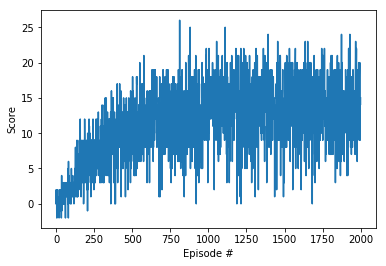

In [11]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()